In [1]:
import pandas as pd
df_meta = pd.read_csv("hannum_meta.csv", index_col=0)

In [2]:
import wget
import os
import pandas as pd
import GEOparse as geo

def load_file_as_df(filename):
    if 'matrix' in filename:
        return geo.get_GEO(geo='GSE40279', destdir='./')

    url = f"https://ftp.ncbi.nlm.nih.gov/geo/series/GSE40nnn/GSE40279/suppl/{filename}"

    if not os.path.exists(filename):
        wget.download(url)

    df = pd.read_csv(filename, sep="\t", compression="gzip", index_col=0)
    return df

df_data = load_file_as_df("GSE40279_average_beta.txt.gz")

In [3]:
df_meta.head()

,name,age,gender,ethnicity
0,X1001,67,F,C
1,X1002,89,F,C
2,X1003,66,F,C
3,X1004,64,F,C
4,X1005,62,F,C


In [4]:
# transpose the data and rename ID_REF to name
df_data = df_data.T.rename(columns={"ID_REF": "name"})

In [5]:
df_data.head()

ID_REF,cg13869341,cg14008030,cg12045430,cg20826792,cg00381604,cg20253340,cg21870274,cg03130891,cg24335620,cg16162899,...,cg27124406,cg19565306,cg22012975,cg10353737,cg22531257,cg22662321,cg06996138,cg16817496,cg07660283,cg09226288
X1001,0.849261,0.505916,0.072590,0.186961,0.036803,0.661391,0.777891,0.119538,0.782193,0.905126,...,0.079514,0.003605,0.016267,0.058144,0.016545,0.044135,0.021236,0.291702,0.727581,0.705499
X1002,0.897434,0.476842,0.079020,0.228201,0.053161,0.545065,0.776407,0.063938,0.787890,0.913628,...,0.080328,0.004043,0.008628,0.044876,0.014927,0.058587,0.019314,0.232008,0.693993,0.716328
X1003,0.751596,0.487245,0.089230,0.237660,0.045588,0.560305,0.774234,0.113279,0.788896,0.914348,...,0.079417,0.003508,0.004635,0.041357,0.024015,0.058990,0.016854,0.296456,0.703291,0.703523
X1004,0.871313,0.466692,0.076666,0.253624,0.032824,0.509904,0.772503,0.067163,0.800081,0.882308,...,0.080837,0.005296,0.006407,0.041691,0.030413,0.064237,0.019278,0.270818,0.751772,0.696888
X1005,0.775703,0.490255,0.079986,0.220404,0.035804,0.549847,0.730345,0.131637,0.759171,0.902783,...,0.084922,0.016451,0.007065,0.060183,0.015760,0.064953,0.016097,0.236963,0.746697,0.693056


<AxesSubplot:>

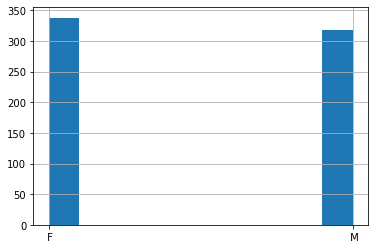

In [6]:
df_meta['gender'].hist()

<AxesSubplot:>

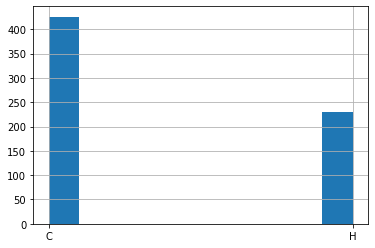

In [7]:
df_meta['ethnicity'].hist()

<AxesSubplot:>

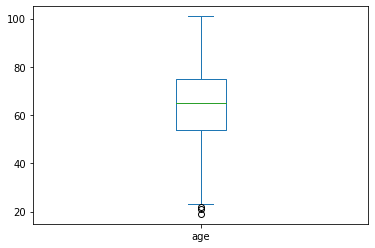

In [8]:
df_meta['age'].plot(kind='box')

In [37]:
import numpy as np
X, y = df_data.values, df_meta['age']
# create a mask to filter out by gender
mask_gender = np.array([True if x == ' F' else False for x in df_meta['gender'].values])
# create a mask to filter out by ethnicity
mask_ethnicity = np.array([True if x == 'H' else False for x in df_meta['ethnicity'].values])
# shuffle the datasets
from sklearn.utils import shuffle
X, y, mask_gender, mask_ethnicity = shuffle(X, y, mask_gender, mask_ethnicity, random_state=0)

In [54]:
# create male and female datasets by applying the mask_gender on X and y
X_female, y_female = X[mask_gender.astype(bool)], y[mask_gender.astype(bool)]
X_male, y_male = X[np.logical_not(mask_gender.astype(bool))], y[np.logical_not(mask_gender.astype(bool))]
X_hispanic, y_hispanic = X[mask_ethnicity.astype(bool)], y[mask_ethnicity.astype(bool)]
X_non_hispanic, y_non_hispanic = X[np.logical_not(mask_ethnicity.astype(bool))], y[np.logical_not(mask_ethnicity.astype(bool))]

In [56]:
print(X_female.shape)
print(X_male.shape)
assert(X.shape[0] == X_female.shape[0]+X_male.shape[0])
print(X_hispanic.shape)
print(X_non_hispanic.shape)
assert(X.shape[0] == X_hispanic.shape[0]+X_non_hispanic.shape[0])

(338, 473034)
(318, 473034)
(230, 473034)
(426, 473034)


In [43]:
X_diff = abs(X-X.mean(axis=0))

In [15]:
X_diff

array([[0.03509579, 0.05319805, 0.00499955, ..., 0.00545188, 0.03018119,
        0.10865558],
       [0.01278621, 0.00143635, 0.03675582, ..., 0.00206888, 0.02041741,
        0.02325492],
       [0.03299221, 0.04342475, 0.03475601, ..., 0.06766508, 0.01025029,
        0.01552348],
       ...,
       [0.04277409, 0.03623185, 0.01811438, ..., 0.06674302, 0.04206441,
        0.01297662],
       [0.06298099, 0.04029645, 0.01758758, ..., 0.05241522, 0.03121011,
        0.02872152],
       [0.06161741, 0.03463245, 0.00056961, ..., 0.04055172, 0.03316209,
        0.01001478]])

In [20]:
# use PCA to reduce the dimensionality of the data
from sklearn.decomposition import PCA
pca = PCA(n_components=20)
pca.fit(X)
print(sum(pca.explained_variance_ratio_))
X_pca = pca.transform(X)
X_pca.shape, y.shape


0.3294036035408146


((656, 20), (656,))

In [22]:
from sklearn.decomposition import FastICA
ica = FastICA(n_components=100, random_state=0)
ica.fit(X)
X_ica = ica.transform(X)
X_ica.shape, y.shape

c:\Users\nyiri\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:488: FutureWarning: From version 1.3 whiten='unit-variance' will be used by default.
  warnings.warn(


((656, 100), (656,))

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

def try_algos(X, y):
    for model in (LinearRegression(),Ridge(),Lasso(),ElasticNet()):
        score = cross_val_score(model, X, y, cv=10, scoring='neg_mean_absolute_error').mean()
        print(f'{model.__class__} score: {score}')

def try_algo_slow(X, y):
    for model in (SVR(), RandomForestRegressor()):
        score = cross_val_score(model, X, y, cv=10, scoring='neg_mean_absolute_error').mean()
        print(f'{model.__class__} score: {score}')

In [16]:
try_algos(X_diff, y)

<class 'sklearn.linear_model._base.LinearRegression'> score: -8.325895947155487
<class 'sklearn.linear_model._ridge.Ridge'> score: -8.329538037930693
<class 'sklearn.linear_model._coordinate_descent.Lasso'> score: -11.938908576295653
<class 'sklearn.linear_model._coordinate_descent.ElasticNet'> score: -11.933418232754981


In [13]:
try_algos(X, y)

<class 'sklearn.linear_model._base.LinearRegression'> score: -4.804712752973408
<class 'sklearn.linear_model._ridge.Ridge'> score: -4.806817811704396
<class 'sklearn.linear_model._coordinate_descent.Lasso'> score: -9.633317159389955
<class 'sklearn.linear_model._coordinate_descent.ElasticNet'> score: -10.362261691040047


In [54]:
try_algos(X_pca, y)

<class 'sklearn.linear_model._base.LinearRegression'> score: -6.408264765894716
<class 'sklearn.linear_model._ridge.Ridge'> score: -6.3564342514911285
<class 'sklearn.linear_model._coordinate_descent.Lasso'> score: -6.0587119099139555
<class 'sklearn.linear_model._coordinate_descent.ElasticNet'> score: -5.461326230620002


In [53]:
try_algos(X_ica, y)

<class 'sklearn.linear_model._base.LinearRegression'> score: -6.640007356904356
<class 'sklearn.linear_model._ridge.Ridge'> score: -7.866463238075053
<class 'sklearn.linear_model._coordinate_descent.Lasso'> score: -11.938908576295653
<class 'sklearn.linear_model._coordinate_descent.ElasticNet'> score: -11.938908576295653


In [23]:
try_algo_slow(X_ica, y)

<class 'sklearn.svm._classes.SVR'> score: -9.17341652450538
<class 'sklearn.ensemble._forest.RandomForestRegressor'> score: -8.275579487179488


In [57]:
try_algos(X_hispanic, y_hispanic)

<class 'sklearn.linear_model._base.LinearRegression'> score: -5.889174574769078
<class 'sklearn.linear_model._ridge.Ridge'> score: -5.891804343641816
<class 'sklearn.linear_model._coordinate_descent.Lasso'> score: -8.244990652234828
<class 'sklearn.linear_model._coordinate_descent.ElasticNet'> score: -8.587478495925307


In [58]:
try_algos(X_non_hispanic, y_non_hispanic)

<class 'sklearn.linear_model._base.LinearRegression'> score: -5.498500924966136
<class 'sklearn.linear_model._ridge.Ridge'> score: -5.500734390450178
<class 'sklearn.linear_model._coordinate_descent.Lasso'> score: -9.995304197446256
<class 'sklearn.linear_model._coordinate_descent.ElasticNet'> score: -10.346673224113125
